# How many planets will we find in the Magellanic Clouds?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange
import astropy.constants as co
import astropy.units as u
import batman
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.stats import BoxLeastSquares

plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [9]:
def make_light_curve_nights(period_days, radius, cadence_minutes, precision, 
                            baseline=9, interval=1, months=4, nights=True):
#     assert radius <= 1., "The radius of your planet can't be greater than the radius of the star."
    
    period_s = period_days * 24 * 3600
    period_s = period_s*u.s
    G = 6.67e-11
    M = 2e30
    a = (period_s**2*co.G*co.M_sun/(4*np.pi**2))**(1./3)/co.R_sun

    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = np.random.uniform(0, 20)  # 0.                 #time of inferior conjunction
    params.per = period_days # period_days                   #orbital period
    params.rp = radius                       #planet radius (in units of stellar radii)
    params.a = a # (period_s**2*G*M/(4*np.pi**2))/6.955e8  #semi-major axis (in units of stellar radii)
    params.inc = 90.                      #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"        #limb darkening model
    params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

    cadence = cadence_minutes/(24*60)  # 30 minute cadence in days
    t = np.arange(0, baseline + months*28, cadence)  #times at which to calculate light curve [days]
    
    if nights:
        ns = range(0, baseline, interval)  # the nights to observe
        times = []
        for k in range(months):
            for j in ns:
                n = 24*j + (28*24*k) < t*24
                n &= t*24 < 24*j + 6 + (28*24*k)
                times += list(t[n])
        t = np.array(times)
    
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)          #calculates light curve
#     flux = np.ones(len(t))
    f = flux + np.random.randn(len(t))*precision*1e-2
    return t, f

(0, 10)

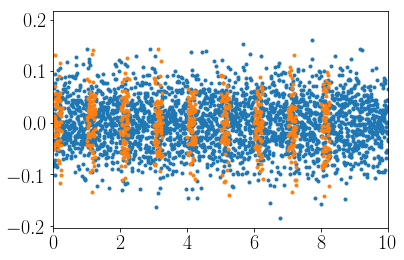

In [11]:
period_days = 1.  # period in days
cadence_minutes = 5  # cadence in minutes
radius = .2 * co.R_sun.value  # 2 Jupiter radii in stellar radii
precision = 5  # percent

t, f = make_light_curve_nights(period_days, radius, cadence_minutes, precision, 
                               baseline=9, interval=1, months=1, nights=False)
plt.plot(t, f, ".")
t, f = make_light_curve_nights(period_days, radius, cadence_minutes, precision, 
                               baseline=9, interval=1, months=1, nights=True)
plt.plot(t, f, ".")

plt.xlim(0, 10)

In [12]:
rjup = co.R_jup/co.R_sun

def run_bls(porbs, radii, cadence_minutes=5, precision=5, 
            baseline=9, interval=1, months=4,
            nights=False, threshold=15):
    
    N = len(porbs)
    recovered, maxpower, tces, t0 = [np.zeros((N)) for i in range(4)]
    for i in trange(N):
        t, f = make_light_curve_nights(porbs[i], radii[i], cadence_minutes, precision, 
                                       baseline=baseline, interval=interval, months=months,
                                       nights=nights)
        model = BoxLeastSquares(t, f, dy=precision*1e-2)
        periodogram = model.autopower(durations)
        
        index = periodogram.power == max(periodogram.power)
        
        t0[i] = periodogram.transit_time[index][0]
        recovered[i] = periodogram.period[index][0]
        maxpower[i] = max(periodogram.power)
        if maxpower[i] > threshold:
            tces[i] = 1
        
        # Make periodogram plot
        plt.plot(periodogram.period, periodogram.power)
        plt.axvline(porbs[i], color="tab:orange", ls="--")
        plt.title("{}".format(radii[i]/rjup))
        plt.savefig("plots/{0}".format(str(i).zfill(4)))
        plt.close()
        
        # Make lc plot
        plt.plot(t, f, ".")
        plt.title("{}".format(radii[i]/rjup))
        plt.savefig("plots/{0}_lc".format(str(i).zfill(4)))
        plt.close()
        
        # Make folded lc plot
        period = recovered[i]
        plt.plot((t - t0[i] + 0.5*period) % period - 0.5*period, f, ".")
        plt.title("{}".format(radii[i]/rjup))
        plt.savefig("plots/{0}_fold".format(str(i).zfill(4)))
        plt.close()
        
    return recovered, maxpower, tces, t0

In [17]:
def make_plot(recovered, tces, porbs, radii):

    success = abs(porbs - recovered)/porbs
    success_m = success < .05 
    success_m &= tces == 1
    recovered_p, recovered_r = porbs[success_m], radii[success_m]
    print(len(recovered_p), "recovered planets")
    print(len(recovered_r[recovered_r/rjup < 1.]), "planets smaller than Jupiter")
    
#     H_true, xedges, yedges = np.histogram2d(np.log10(porbs), radii/rjup, bins=5)
    H_true, xedges, yedges = np.histogram2d(np.log10(porbs), radii, bins=5)
#     H_recovered, _, _ = np.histogram2d(np.log10(recovered_p), recovered_r/rjup, bins=(xedges, yedges))
    H_recovered, _, _ = np.histogram2d(np.log10(recovered_p), recovered_r, bins=(xedges, yedges))
    H = H_recovered/H_true
    X, Y = np.meshgrid(xedges, yedges)
    
    plt.figure(figsize=(16, 9))
#     plt.plot(np.log10(porbs), radii/rjup, ".", color="tab:orange", ms=10)
#     plt.plot(np.log10(recovered_p), recovered_r/rjup, ".", color="tab:blue", ms=3)
    plt.plot(np.log10(porbs), radii, ".", color="tab:orange", ms=10)
    plt.plot(np.log10(recovered_p), recovered_r, ".", color="tab:blue", ms=3)
    plt.pcolormesh(X, Y, H.T, vmin=0., vmax=.5)#vmax=max(H.flatten())+.1)
    plt.xlabel("$\log_{10}(\mathrm{Orbital~Period~[days]})$")
    plt.ylabel("$\mathrm{Planet~Radius~[R_J]}$")
    plt.ylabel("$\mathrm{Radius~[R_*]}$")
    plt.colorbar(label="$\mathrm{Fraction~Recovered}$")
    plt.savefig("completeness_binaries.pdf")
    plt.savefig("completeness_binaries.eps")
    return H

In [22]:
N = 1000
porbs = 10**(np.random.uniform(-.5, 1, N))
radii = np.random.uniform(15, 25, N)*rjup
durations = np.linspace(0.05, 0.2, 10)  # days

In [ ]:
start = time.time()
recovered, maxpower, tces, t0 = run_bls(porbs, radii, cadence_minutes=5, precision=5.3, 
                                        baseline=9, interval=1, months=1, nights=True)
end = time.time()
print((end - start)/60, "minutes")

 99%|█████████▉| 992/1000 [29:20<00:15,  1.99s/it]

8 recovered planets
0 planets smaller than Jupiter


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


[[0.5 0.5 nan 0.  0. ]
 [nan nan 0.  1.  nan]
 [nan 1.  nan 0.  0. ]
 [1.  1.  1.  0.  0. ]
 [nan 1.  nan nan 0. ]]


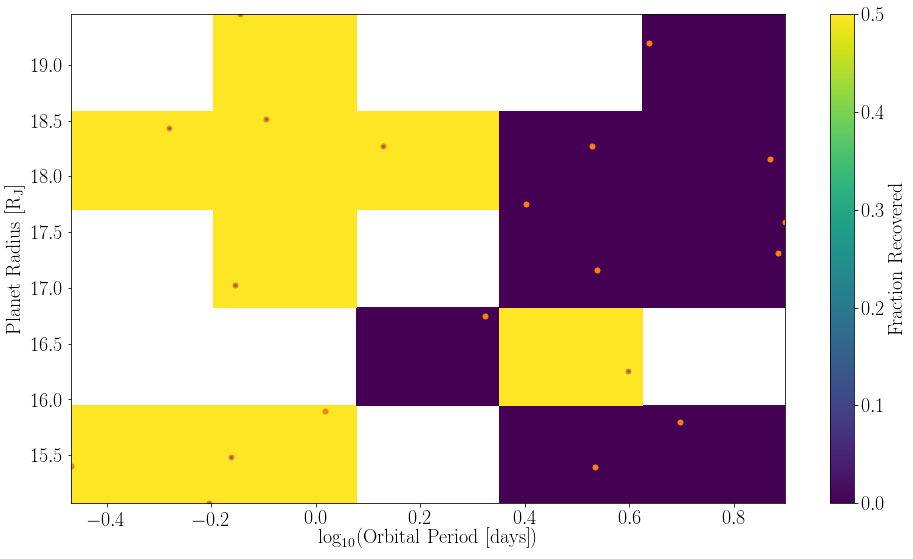

In [21]:
H_5min = make_plot(recovered, tces, porbs, radii)
print(H_5min.T)